In [1]:
import pandas as pd
from pandas import DataFrame
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import random

# Data cleaning

With this notebook, we'll be cleaning a dataset of audio features from music tracks downloaded from the Spotify API.

### a) Initial exploration

First, we'll look at the overall description of our dataset to see if any issues jump out.

In [2]:
tracks: DataFrame = pd.read_csv('data/audio_features_4.0.csv')
tracks = tracks.drop('id', axis=1)

In [3]:
tracks.describe()

danceability         energy            key       loudness  \
count  916668.000000  916668.000000  916668.000000  916668.000000   
mean        0.537007       0.654988       5.289780      -8.733212   
std         0.182291       0.258401       3.563508       5.241114   
min         0.000000       0.000000       0.000000     -60.000000   
25%         0.414000       0.483000       2.000000     -10.771000   
50%         0.547000       0.706000       5.000000      -7.438000   
75%         0.673000       0.875000       8.000000      -5.231000   
max         0.990000       1.000000      11.000000       5.842000   

                mode    speechiness   acousticness  instrumentalness  \
count  916668.000000  916668.000000  916668.000000     916668.000000   
mean        0.638696       0.083720       0.283064          0.217647   
std         0.480379       0.104858       0.333119          0.343082   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.035900       0.005630          0.000002   
50%         1.000000       0.048600       0.111000          0.001270   
75%         1.000000       0.083800       0.531000          0.401000   
max         1.000000       0.968000       0.996000          1.000000   

            liveness        valence          tempo   duration_ms  \
count  916668.000000  916668.000000  916668.000000  9.166680e+05   
mean        0.201232       0.479339     122.323912  2.362498e+05   
std         0.169247       0.271533      29.771911  1.182468e+05   
min         0.000000       0.000000       0.000000  4.053000e+03   
25%         0.096300       0.249000      99.836000  1.778270e+05   
50%         0.130000       0.470000     121.376000  2.183200e+05   
75%         0.265000       0.704000     140.039000  2.696930e+05   
max         1.000000       1.000000     249.987000  5.676437e+06   

       time_signature  
count   916668.000000  
mean         3.902495  
std          0.421955  
min          0.000000  
25%          4.000000  
50%          4.000000  
75%          4.000000  
max          5.000000

In [4]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916668 entries, 0 to 916667
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      916668 non-null  float64
 1   energy            916668 non-null  float64
 2   key               916668 non-null  float64
 3   loudness          916668 non-null  float64
 4   mode              916668 non-null  float64
 5   speechiness       916668 non-null  float64
 6   acousticness      916668 non-null  float64
 7   instrumentalness  916668 non-null  float64
 8   liveness          916668 non-null  float64
 9   valence           916668 non-null  float64
 10  tempo             916668 non-null  float64
 11  duration_ms       916668 non-null  float64
 12  time_signature    916668 non-null  float64
 13  artist_name       916668 non-null  object 
 14  song_name         916667 non-null  object 
 15  genre             916668 non-null  object 
 16  spotify_track_id  91

In [5]:
print('Overall songs:', len(tracks))
print('Unique genres:', tracks.groupby(by='genre').count().spotify_track_id.count())
print('Mean songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.mean())
print('Median songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.median())
print('Min songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.min())
print('Max songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.max())

Overall songs: 916668
Unique genres: 132
Mean songs per genre: 6944.454545454545
Median songs per genre: 5776.5
Min songs per genre: 788
Max songs per genre: 19061


Overall, it looks like there are no null values, but some of the features have potential problems. Tempo and time_signature both go down to zero, which doesn't make sense musically. (Note: Loudness has a negative value because decibels are reported relative to a reference value.)

Let's look at how many tempo and time_signature values are zero or near-zero.

In [6]:
print('Tempo below 10:', tracks[tracks.tempo < 10].count().tempo)
print('Tempo at 0:', tracks[tracks.tempo == 0].count().tempo)
print('Time_signature below 1:', tracks[tracks.time_signature < 1].count().time_signature)
print('Time_signature at 0:', tracks[tracks.time_signature == 0].count().time_signature)

Tempo below 10: 444
Tempo at 0: 444
Time_signature below 1: 454
Time_signature at 0: 454


In [7]:
tempo_mask = tracks.tempo < 10
time_mask = tracks.time_signature < 1
tracks[tempo_mask | time_mask].sample()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
634870           0.0   0.194  0.0   -19.114   0.0          0.0         0.491   

        instrumentalness  liveness  valence  tempo  duration_ms  \
634870             0.881     0.112      0.0    0.0     174635.0   

        time_signature    artist_name          song_name       genre  \
634870             0.0  Antonio Pinto  God - Senna Theme  Soundtrack   

              spotify_track_id  
634870  3qVI0glCZscaCREU4YRev2

Almost all the tracks that have zero tempo or time_signature have zero values for both. Furthermore, there are only a small number of rows with either of these features equal to zero. Because this is likely bad data, we will drop these rows.

In [8]:
tracks = tracks[~(tempo_mask | time_mask)]

### b) Duplicates

Next we will look at duplicates. Because we downloaded top artists by genre and top tracks by artist, there might be some overlap, with some tracks in multiple genres or associated with multiple artists. 

To simplify things, let's start by looking at the tracks that have every characteristic in common. After we tackle this problem, we can worry about songs that are similar, but have one or two attributes (like artist name or genre) listed differently.

In [9]:
print('Percent of rows with duplicates for all features:', len(tracks[tracks.duplicated()]) / len(tracks))

Percent of rows with duplicates for all features: 0.19468377475131357


We'll go ahead and drop these rows, which are redundant.

In [10]:
print('Datapoints before drop:', len(tracks))
tracks = tracks[~tracks.duplicated()]
print('Datapoints after drop:', len(tracks))

Datapoints before drop: 916214
Datapoints after drop: 737842


Next, we'll look at songs with duplicate Spotify song ID and name in the dataset.

In [11]:
track_id_dup = tracks.spotify_track_id.duplicated()
song_name_dup = tracks.song_name.duplicated()

print('Percent duplicate name and unique ID:', len(tracks[~track_id_dup & song_name_dup]) / len(tracks))
print('Percent duplicate ID and unique name:', len(tracks[track_id_dup & ~song_name_dup]) / len(tracks))
print('Percent duplicate ID and name:', len(tracks[track_id_dup & song_name_dup]) / len(tracks))

Percent duplicate name and unique ID: 0.1687054952144226
Percent duplicate ID and unique name: 0.0
Percent duplicate ID and name: 0.25418314490094085


There are no songs with the same ID and different names. Start by investigating songs with duplicate names but unique IDs.

In [12]:
WINDOW_SIZE = 4
random_center = random.randint(WINDOW_SIZE / 2, len(tracks[~track_id_dup & song_name_dup]) - WINDOW_SIZE / 2)
tracks[~track_id_dup & song_name_dup].sort_values(by='song_name')[random_center - WINDOW_SIZE:random_center + WINDOW_SIZE]

danceability  energy   key  loudness  mode  speechiness  acousticness  \
594127         0.753   0.698   7.0    -5.789   0.0       0.0597        0.1310   
744076         0.699   0.978   1.0    -1.525   0.0       0.2680        0.0257   
495270         0.583   0.661  11.0    -9.766   1.0       0.0425        0.8900   
593878         0.834   0.556   4.0    -9.570   0.0       0.0282        0.1830   
458739         0.710   0.786  10.0    -8.420   0.0       0.0651        0.1990   
595507         0.838   0.546   4.0    -9.610   0.0       0.0283        0.1790   
460844         0.513   0.799   4.0    -7.322   0.0       0.0789        0.3720   
597761         0.619   0.519   1.0   -12.815   1.0       0.0355        0.1150   

        instrumentalness  liveness  valence    tempo  duration_ms  \
594127          0.000017    0.0472    0.953   95.283     264934.0   
744076          0.000986    0.3640    0.946  159.951     204004.0   
495270          0.000098    0.1470    0.954  107.025     128333.0   
593878          0.000000    0.1070    0.796  103.961     221022.0   
458739          0.000000    0.1180    0.537   99.906     240843.0   
595507          0.000000    0.0983    0.767  103.977     223033.0   
460844          0.000000    0.0667    0.744  101.385     268240.0   
597761          0.000000    0.3460    0.954  149.897     194400.0   

        time_signature                     artist_name  \
594127             4.0  Aniceto Molina Y Sus Sabaneros   
744076             4.0                          Ablaze   
495270             4.0               Perlita de Huelva   
593878             4.0                         Algodon   
458739             4.0                        Jay Lugo   
595507             4.0                   Grupo Algodon   
460844             4.0                        PP Banda   
597761             4.0               El Flaco Alvarado   

                       song_name     genre        spotify_track_id  
594127  El Diario De Un Borracho    Cumbia  719fQK6aEHdsGsL8KVGWnV  
744076                 El Dinero   Dubstep  7x0pgB3lAvkZspyOyk9gbl  
495270               El Divorcio  Flamenco  56TWwyrBNxaiENnUlMbOuj  
593878               El Divorcio    Cumbia  60uuy5wl68bFeCfGeBty2c  
458739               El Divorcio     Salsa  25FLET82WXEmgoG6sqo9BZ  
595507               El Divorcio    Cumbia  7igdLogEGgJBnMm6PXBxUZ  
460844               El Divorcio     Salsa  1ACcNVIHVTyaVKRvFsKMqr  
597761               El Divorcio    Cumbia  7Bbjlvx3N6nOrRKgRSV0Ab

By sampling our dataset, we can see that there are common names that are used by different songs (like "I Want You" and "Aftermath"). It appears that these are mostly not duplicate songs, and so we won't drop them for now. 

A separate issue is songs that have both a duplicate ID and song name. Let's look at a selection of those data points.

In [13]:
tracks[track_id_dup & song_name_dup].sort_values(by='spotify_track_id')[100:110]

Most of these songs with duplicate names and Spotify IDs are either cross-listed under various artists or various genres. For these songs, we'll drop the rows with different versions of the same track. This loses some data, but avoids the complication of classifying a song into multiple genres, which we don't have data for in the majority of cases. This approach allows our model to learn from each song, while also limiting the complexity for our initial modeling.

In [14]:
print('Datapoints before drop:', len(tracks))
tracks = tracks.drop_duplicates(subset=['spotify_track_id', 'song_name'])
print('Datapoints after drop:', len(tracks))

Datapoints before drop: 737842
Datapoints after drop: 550295


In [15]:
track_id_dup = tracks.spotify_track_id.duplicated()
song_name_dup = tracks.song_name.duplicated()

print('Percent duplicate name and unique ID:', len(tracks[~track_id_dup & song_name_dup]) / len(tracks))
print('Percent duplicate ID and unique name:', len(tracks[track_id_dup & ~song_name_dup]) / len(tracks))
print('Percent duplicate ID and name:', len(tracks[track_id_dup & song_name_dup]) / len(tracks))

Percent duplicate name and unique ID: 0.22620230967026778
Percent duplicate ID and unique name: 0.0
Percent duplicate ID and name: 0.0


### c) Outliers

Let's see what other outliers might be in our data using boxplots and Inter-Quartile Range. We'll be able to see datapoints that fall more than 1.5 times IQR away from the mean. This will suggest additional outliers. 

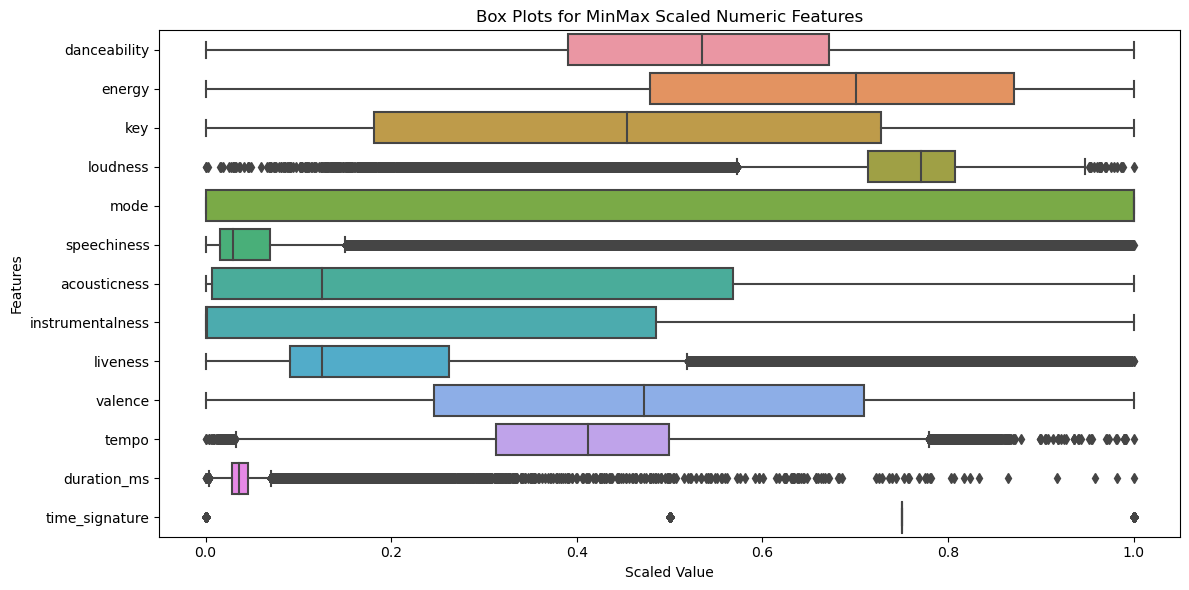

In [16]:
numeric_cols = [col for col in tracks.columns if pd.api.types.is_numeric_dtype(tracks[col])]
boxplot_tracks = tracks[numeric_cols]

# Scale the features using MinMaxScaler for visualization purposes
scaled_data = MinMaxScaler().fit_transform(boxplot_tracks)
boxplot_tracks_scaled = pd.DataFrame(scaled_data, columns=boxplot_tracks.columns)

# Plot box plots for each feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_tracks_scaled, orient='h')
plt.title('Box Plots for MinMax Scaled Numeric Features')
plt.xlabel('Scaled Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

It looks like there are significant numbers of outliers as defined by IQR. Let's make a pairplot to check the distribution of each feature that had outliers. 

We'll leave out time_signature, because this data all falls into the range 1-5, and we can't reasonably classify a song in an abnormal time signature as an outlier.

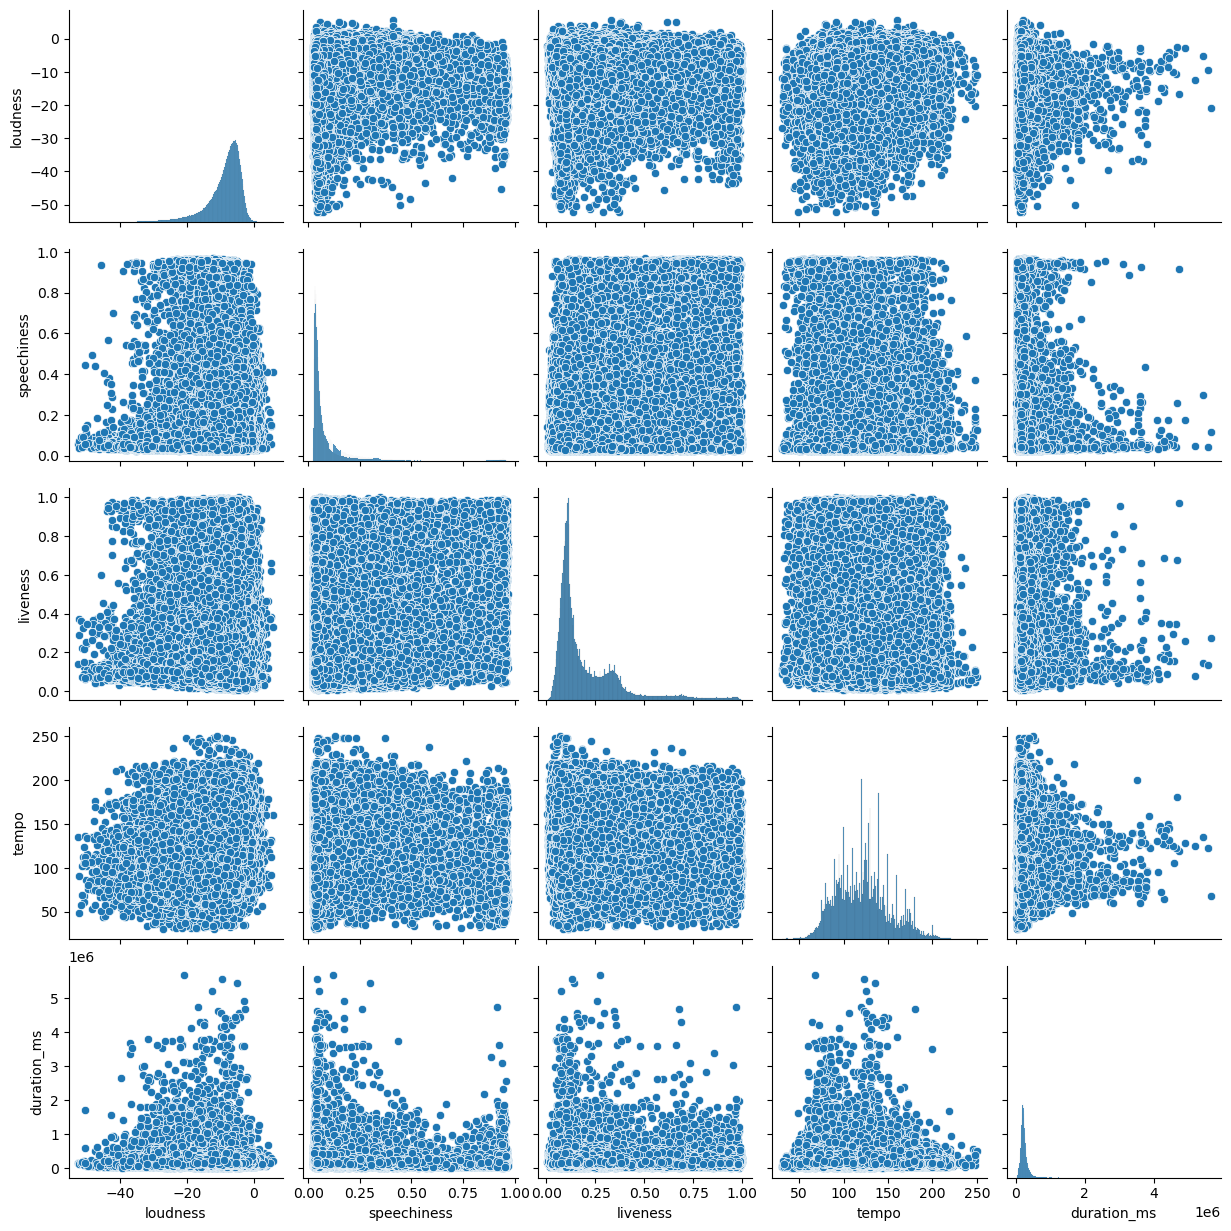

In [17]:
sns.pairplot(tracks.loc[:, ['loudness', 'speechiness', 'liveness', 'tempo', 'duration_ms']])
plt.show()

Loudness, speechiness, and liveness are all skewed with high kurtosis, with loudness being skewed towards 0 (indicating proximity to Spotify's decibel threshold), and speechiness and liveness being skewed towards 0. This distribution helps explain the high number of outliers captured by the boxplot, which is looking at a symmetric range around the median.

In the context of our data, this makes some sense. Spotify adjusts audio volume, and it makes sense that they wouldn't want music that's too quiet, or music above their decibel threshold. 

It also make some sense that liveness would cluster around zero, as most music is studio-recorded rather than live-recorded. 

For speechiness, which measures how much spoken (rather than sung or instrumental) sound there is in a track, it seems plausible that most tracks just don't qualify as speechy.

Next, we'll take a look at the distribution of outliers per row and explore the characteristics of the rows with a high concentration of outliers in one place.

In [18]:
# Calculate the lower and upper bound for each column
Q1 = tracks.quantile(0.25)
Q3 = tracks.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers in each row
outliers_mask = (tracks < lower_bound) | (tracks > upper_bound)

# Count the number of outliers per row
outliers_per_row = outliers_mask.sum(axis=1)

# Filter rows with at least one outlier
rows_with_outliers = outliers_per_row[outliers_per_row > 0]

# Analyze the distribution of outliers-per-row
outliers_distribution = rows_with_outliers.value_counts().sort_index()
print(outliers_distribution)

C:\Users\jackv\AppData\Local\Temp\ipykernel_10872\2314039613.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_mask = (tracks < lower_bound) | (tracks > upper_bound)


1    137930
2     32545
3      6278
4       616
5        45
dtype: int64


Once we start looking at rows with 4-5 outliers, there aren't many matching data points. Let's look at a sample of these rows and listen to some of the songs as a sanity check.

In [19]:
# Identify the outliers in each row
outliers_mask = (tracks < lower_bound) | (tracks > upper_bound)

outliers_per_row = outliers_mask.sum(axis=1)
rows_with_outliers = outliers_per_row[outliers_per_row > 0]
outliers_groups = rows_with_outliers.groupby(rows_with_outliers).groups

# Sample rows from each category
sample_size = 3  
random_seed = 538  
rng = np.random.default_rng(random_seed)

for num_outliers, row_indices in outliers_groups.items():
    sample_indices = rng.choice(row_indices, size=min(sample_size, len(row_indices)), replace=False)
    sampled_rows = tracks.loc[sample_indices]
    print(f"Sample rows with {num_outliers} outliers:")
    print(sampled_rows)

C:\Users\jackv\AppData\Local\Temp\ipykernel_10872\3253434263.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_mask = (tracks < lower_bound) | (tracks > upper_bound)


Sample rows with 1 outliers:
        danceability  energy  key  loudness  mode  speechiness  acousticness  \
408519         0.627   0.447  5.0    -9.159   0.0       0.2200         0.227   
93146          0.460   0.968  4.0    -3.180   0.0       0.3110         0.023   
121736         0.760   0.467  1.0    -2.213   1.0       0.0371         0.866   

        instrumentalness  liveness  valence    tempo  duration_ms  \
408519           0.23000     0.260    0.814  156.456     130667.0   
93146            0.00139     0.121    0.141  170.023     275294.0   
121736           0.00259     0.149    0.679   89.975     199579.0   

        time_signature  artist_name                   song_name     genre  \
408519             4.0  The Tennors              Copy Me Donkey       Ska   
93146              4.0        Hixxy  Saving Light - Hixxy Remix    Techno   
121736             5.0          ひらめ              ポケットからきゅんです!  Teen Pop   

              spotify_track_id  
408519  1PmPNcT7oxjTcL60w8ZF9b 

Sample songs with 5 outliers:

- Egg Babies by Bil Lepp. This is a recording of a stand-up performance. Highly live, long, speechy, quiet, and low tempo.
- Deep Stare by STL. This is a Dub Techno track, and it makes heavily use of nature sounds. It is quiet, over 7 minutes, low tempo, and has essentially no speech. The sound of leaves rustling sound a lot like a croud clapping, so this may be the reason for the high liveness score (Spotify uses crowd noise to measure liveness.)

Many of the other songs with a high degree of outliers are comedy shows, audiobooks, and similar recordings. These are not bad data, just different than the majority of the tracks, which are songs.

Are some genres identified consistently as outliers? Let's quickly explore this.

In [20]:
for col in ['loudness', 'speechiness', 'liveness', 'tempo', 'duration_ms']:
    outliers_mask = (tracks[col] < lower_bound[col]) | (tracks[col] > upper_bound[col])
    outliers = tracks[outliers_mask]
    genre_distribution = outliers['genre'].value_counts()
    print(f"Genre distribution for outliers in {col}:")
    print(genre_distribution[:50], '\n') 
    

Genre distribution for outliers in loudness:
Baroque              4336
Classical            3150
Soundtrack           2640
Ambient              2585
Opera                1876
Rai                  1645
New Age              1407
Avant-garde          1396
Orchestral           1385
Experimental         1073
Jazz                 1012
Comedy                620
Jazz Fusion           507
Industrial            386
Celtic                371
Techno                312
Indie Folk            265
Swing                 208
Bossa Nova            189
Singer-songwriter     170
Psychedelic Rock      170
Progressive Rock      169
Cabaret               161
Shoegaze              154
Quebecois             148
Classic Rock          133
Latin                 131
Flamenco              127
Bluegrass             122
Contemporary Folk     121
Folk                  120
Progressive Metal     118
J-pop                 116
Samba                 111
Electronic            111
Indie Pop             109
Adult Standards    

This check seems to provide further evidence that our outliers are good data.

For loudness, the majority of outliers are classical, ambient, or traditional music. 

For speechiness, we have lots of Guidance, Comedy, and Hip Hop.

For liveness, we have comedy, Gospel, German Show Tunes, Hoerspiel (German radio drama), and Environmental music (which seems to be often misclassified as live).

For tempo, we have genres like Dixieland, Accordian, and Cajun. A cursory listen suggests that these genres are indeed high tempo, although this category seems less clear-cut. (Overall, tempo has by far the fewest outliers of the five features, which decreases the importance of making a determination here.)

For duation_ms, the outliers are gernes like Progressive House, Goa Trance, and Deep Psytrance, which makes perfect sense.

Overall, based on our various investigations it looks like our outliers are not bad data, so we won't drop them.

### d) Final summary before export

Before we export, let's check to see the distribution of genres. We requested the top ten songs of the first 50 artists to appear in search for each genre, but some genres didn't have that many artists available.

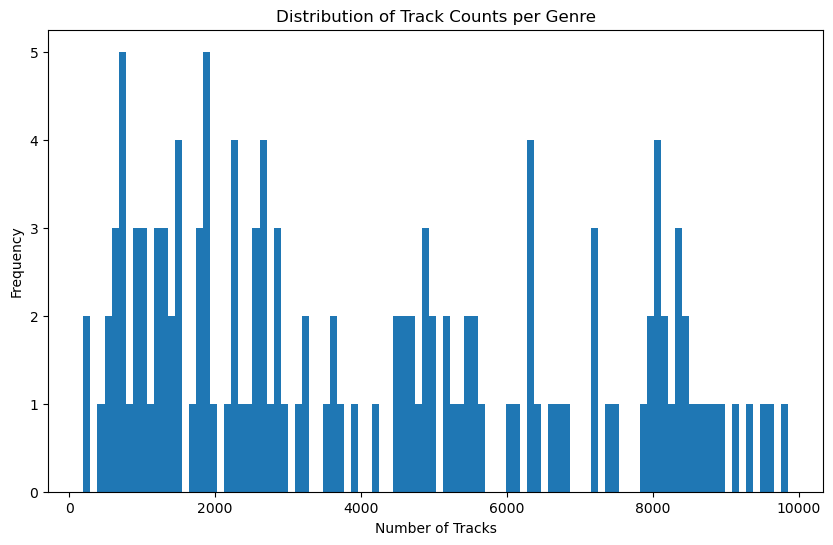

In [21]:
genre_counts = tracks.groupby(by='genre').size().sort_values(ascending=True)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(genre_counts, bins=100)
plt.xlabel('Number of Tracks')
plt.ylabel('Frequency')
plt.title('Distribution of Track Counts per Genre')
plt.show()

Our tracks are clustered towards the genres we requested, but there is a non-trivial number of genres without much representation. Let's get a more precise picture by looking at the track counts per genre, sorted by tracks-per-genre.

In [22]:
tracks.groupby(by='genre').size().sort_values(ascending=True).head(20)

genre
Funk Rock         196
Madchester        251
Skiffle           399
Art Rock          541
Glam Rock         577
Acid House        603
Cowpunk           659
Acid Jazz         664
Dark Wave         684
Electroclash      692
Calypso           698
Country Blues     707
Dance-punk        707
Funky Breaks      859
Shibuya-kei       882
Hiplife           913
Mambo             964
Chiptune          991
Delta Blues      1029
Rock             1033
dtype: int64

And finally, we'll get an overall summary of our dataset after cleaning. The number of songs has reduced significantly, but there is still decent representation in most genres.

In [23]:
print('Overall songs:', len(tracks))
print('Unique genres:', tracks.groupby(by='genre').count().spotify_track_id.count())
print('Mean songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.mean())
print('Median songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.median())
print('Min songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.min())
print('Max songs per genre:', tracks.groupby(by='genre').count().spotify_track_id.max())

Overall songs: 550295
Unique genres: 132
Mean songs per genre: 4168.901515151515
Median songs per genre: 3557.0
Min songs per genre: 196
Max songs per genre: 9851


### Export clean dataset

In [24]:
tracks.to_csv('data/audio_features_4.0_clean.csv', index=False)

# References

- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
- https://pandas.pydata.org/docs/reference/api/pandas.api.types.is_string_dtype.html
- https://seaborn.pydata.org/generated/seaborn.boxplot.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html
- https://numpy.org/doc/stable/reference/random/generator.html